# Protein-like MSM building

Dependencies can be installed in a new conda environment with
`conda env create -f environment.yml`
or installed into an existing environment with
`conda env update --name <existing environment name> --file environment.yml`

# Load dependencies

In [14]:
import MDAnalysis as mda
import MDAnalysis.analysis.rms
import MDAnalysis.analysis.align
import numpy as np
import tqdm.auto as tqdm
from deeptime.clustering import KMeans
from matplotlib import pyplot as plt

## Load DE Shaw trajectories

I'll be using the Trp-cage (2JOF) folding trajectory #2. This is 105 DCD files + a topology .mae, indexed as 0-104.

In [2]:
trajectory_base_path = '/Users/russojd/Research/desres_trajectories/DESRES-Trajectory_2JOF-0-protein 2/2JOF-0-protein'
n_traj_files = 105

traj_name = "2JOF-0-protein-{traj_idx:0>3d}.dcd"

# MDAnalysis can't read the .mae
# topology_name = "2JOF-0-protein.mae"

# So instead, use this PDB I got from converting the .mae
topology_name = "2JOF.pdb"

topology_path = f"{trajectory_base_path}/{topology_name}"
traj_paths = [f"{trajectory_base_path}/{traj_name.format(traj_idx=_idx)}" for _idx in range(n_traj_files)]

In [3]:
# Explicitly set the timestep here, since letting MDAnalysis infer it gives a wonky result.

# Each of my trajectory DCD files start 2e6 units apart
# The very first trajectory starts at 200 units
# The whole trajectory is 208µs, and all the trajectories are 1e6 units, so a unit is 200ps.

dt = 200

In [4]:
universe = mda.Universe(topology_path, traj_paths, dt=dt )

In [5]:
total_time_ps = len(universe.trajectory) * universe.trajectory.dt

print(f"Total trajectory time is {total_time_ps/1e6} µs")

Total trajectory time is 208.8 µs


## Prepare trajectory (align+center)

This aligns alpha-carbons on the provided reference topology, and spits out the result in `aligned_2JOF.dcd`. This only needs to be run once, to make that file.

# Model-building

In [25]:
# Stride the trajectory
stride = 10

# Number of clusters for k-means
n_clusters = 100

## Featurize trajectory

In the original Shaw publication, they featurized the folding transition with alpha-carbon RMSD.

[MDAnalysis RMSD documentation](https://www.mdanalysis.org/MDAnalysisTutorial/analysismodule.html#rmsd)

In [20]:
aligned = mda.Universe(topology_path, 'aligned_2JOF.dcd')
alpha_carbons = aligned.select_atoms('name CA')
initial_positions = alpha_carbons.positions.copy()

In [26]:
rmsd = np.full(shape=len(aligned.trajectory)//stride, fill_value=np.nan)

# alpha_carbons = aligned.select_atoms('name CA')

for i, frame in tqdm.tqdm(enumerate(aligned.trajectory), total=len(aligned.trajectory), miniters=1e5, mininterval=1):

    if not i%stride == 0:
        continue

    # Compute the alpha-carbon RMSD at each frame
    frame_positions = alpha_carbons.positions
    frame_rmsd = MDAnalysis.analysis.rms.rmsd(initial_positions, frame_positions)

    if i//stride < len(aligned.trajectory)//stride:
        rmsd[i//stride] = frame_rmsd

  0%|          | 0/1044000 [00:00<?, ?it/s]

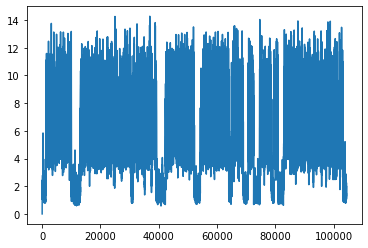

In [27]:
plt.plot(rmsd)

## Discretize trajectory

We'll just do a simple k-means clustering on the RMSDs.

[Deeptime k-means clustering documentation](https://deeptime-ml.github.io/latest/notebooks/clustering.html)

In [92]:
# Initialize the estimator
kmeans_estimator = KMeans(
    n_clusters=n_clusters,
    init_strategy='uniform',
    max_iter=1000,
    fixed_seed=1337,
    n_jobs=4
)

In [93]:
# Perform the clustering
clustering = kmeans_estimator.fit(rmsd).fetch_model()

/Users/russojd/opt/anaconda3/envs/protein-like_msm/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:458: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 1000 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


In [95]:
# Discretize the trajectory
discrete_trajectory = clustering.transform(rmsd)

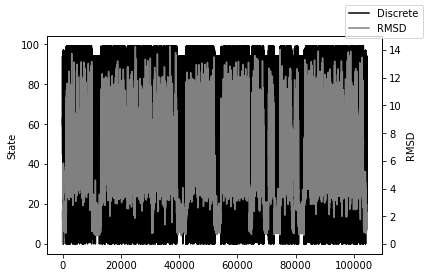

In [96]:
# Plot the RMSDs and discrete trajectory
fig, discrete_ax = plt.subplots(1,1)
rmsd_ax = discrete_ax.twinx()

rmsd_ax.plot(rmsd, color='gray', label='RMSD')
rmsd_ax.set_ylabel('RMSD')

discrete_ax.plot(discrete_trajectory, color='k', label='Discrete')
discrete_ax.set_ylabel('State')

fig.legend()

## Build MSM

In [97]:
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM

In [98]:
lag = 1
count_model = TransitionCountEstimator(lag, 'sliding').fit_fetch(discrete_trajectory)
msm = MaximumLikelihoodMSM().fit_fetch(count_model.submodel_largest())

### Visualize results of MSM

In [99]:
# Sort clusters by RMSD, so we get smooth plots of stationary distributions
cluster_sort_order = np.argsort(clustering.cluster_centers, axis=0)

In [100]:
# Get the histogram in each bin from the full trajectory
hist_bins, hist_counts = np.unique(discrete_trajectory, return_counts=True)
hist_counts = hist_counts/sum(hist_counts)

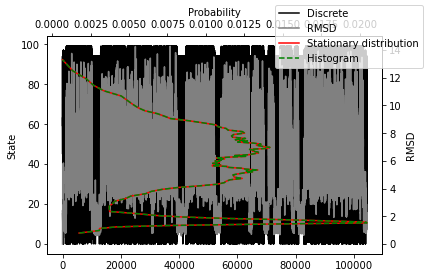

In [101]:
# Plot the RMSDs and discrete trajectory
fig, discrete_ax = plt.subplots(1,1)
rmsd_ax = discrete_ax.twinx()

rmsd_ax.plot(rmsd, color='gray', label='RMSD')
rmsd_ax.set_ylabel('RMSD')
discrete_ax.plot(discrete_trajectory, color='k', label='Discrete')
discrete_ax.set_ylabel('State')
rmsd_ax.set_xlabel('Time (ps)')

stationary_ax = rmsd_ax.twiny()
stationary_ax.plot(
    msm.stationary_distribution[cluster_sort_order],
    clustering.cluster_centers[cluster_sort_order].flatten(),
    color='red',
    label='Stationary distribution'
)
stationary_ax.plot(
    hist_counts[cluster_sort_order],
    clustering.cluster_centers[hist_bins.astype(int)][cluster_sort_order].flatten(),
    color='green',
    linestyle='--',
    label='Histogram'
)
stationary_ax.set_xlabel('Probability')

fig.legend()

### Save the model

In [102]:
np.savez('transition_matrix', transition_matrix=msm.transition_matrix)